### Dataloaders & Co.


In [1]:
import os
import time
from tqdm import tqdm

import clip
import torch
from torch import nn
import torchvision
import numpy as np
from PIL import Image
import numpy as np
import kornia.augmentation as K

import kornia.enhance as Ke
from typing import List, Optional
from torch.utils.data import Dataset, DataLoader

# Seeding
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# visualize images

import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


def plot_images(images):
    cols = 8
    rows = (images.shape[0] + cols - 1) // cols

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(images.shape[0]):
        img = images[i]
        img = TF.to_pil_image(img)  # Convert from [C, H, W] to PIL image

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [51]:
class AugMixKornia:
    def __init__(
        self,
        severity: int = 3,
        width: int = 3,
        depth: int = -1,
        alpha: float = 1.0,
        mixture_width: int = 3,
        chain_depth: int = 3,
        all_ops: bool = True,
        device: Optional[str] = None,
    ):
        """
        AugMix implementation using Kornia with closer fidelity to the original paper.

        Args:
            severity: Severity level of augmentations (1-10)
            width: Width of augmentation chain (not used directly, kept for compatibility)
            depth: Depth of augmentation chain (-1 for random between 1-3)
            alpha: Dirichlet distribution parameter for mixing weights
            mixture_width: Number of augmentation chains to mix
            chain_depth: Number of operations in each chain
            all_ops: Whether to use all augmentation operations
            device: Device to run on (cuda/cpu)
        """
        self.severity = severity
        self.alpha = alpha
        self.mixture_width = mixture_width
        self.chain_depth = chain_depth if depth <= 0 else depth
        self.all_ops = all_ops
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # Define augmentation operations
        self.augmentations = self._get_augmentations()

    def _get_augmentations(self) -> List[nn.Module]:
        """Create a list of augmentation operations that will be randomly applied"""
        severity_factor = self.severity / 10.0

        if self.all_ops:
            # Full set of augmentations similar to original AugMix
            return [
                # AutoContrast
                K.ColorJitter(
                    brightness=0.1 * self.severity, contrast=0.1 * self.severity, p=1.0
                ),
                # Equalize
                Ke.equalize,
                # Posterize
                K.RandomPosterize(bits=max(1, 8 - self.severity), p=1.0),
                # Rotate
                K.RandomRotation(
                    degrees=(-30 * severity_factor, 30 * severity_factor), p=1.0
                ),
                # Solarize
                K.RandomSolarize(
                    thresholds=0.5, additions=(0.0, 0.1 * self.severity), p=1.0
                ),
                # Shear
                K.RandomAffine(
                    degrees=0,
                    shear=(-15 * severity_factor, 15 * severity_factor),
                    p=1.0,
                ),
                # Translate
                K.RandomAffine(
                    degrees=0,
                    translate=(0.1 * severity_factor, 0.1 * severity_factor),
                    p=1.0,
                ),
                # ColorJitter
                K.ColorJitter(
                    brightness=0.1 * self.severity,
                    contrast=0.1 * self.severity,
                    saturation=0.1 * self.severity,
                    hue=0.1,
                    p=1.0,
                ),
            ]
        else:
            # Simplified version
            return [
                K.ColorJitter(
                    brightness=0.1 * self.severity, contrast=0.1 * self.severity, p=1.0
                ),
                Ke.equalize,
                K.RandomAffine(
                    degrees=(-15 * severity_factor, 15 * severity_factor), p=1.0
                ),
            ]

    def _apply_augmentation_chain(self, image: torch.Tensor) -> torch.Tensor:
        """
        Apply a random sequence of augmentations to an image.

        Args:
            image: Input image tensor (C, H, W)

        Returns:
            Augmented image tensor (C, H, W)
        """
        # Randomly select augmentations for this chain
        op_indices = np.random.choice(
            len(self.augmentations), size=self.chain_depth, replace=True
        )

        # Apply augmentations in random order
        # augmented = image.clone()
        # for op_idx in op_indices:
        # op = self.augmentations[op_idx]
        # augmented = op(augmented.unsqueeze(0)).squeeze(0)

        augmented = image  # Don't clone immediately
        for op_idx in op_indices:
            augmented = self.augmentations[op_idx](augmented)

        return augmented.squeeze(0)

    def __call__(self, images: torch.Tensor) -> torch.Tensor:
        """
        Apply AugMix to a batch of images.

        Args:
            images: Input batch of images (B, C, H, W) or (C, H, W)

        Returns:
            Augmented batch (same shape as input)
        """
        # Input validation
        if not isinstance(images, torch.Tensor):
            images = K.image_to_tensor(images)

        if images.dim() == 3:
            images = images.unsqueeze(0)

        # Move to device if needed
        if images.device != self.device:
            images = images.to(self.device)

        batch_size = images.shape[0]

        # Sample mixing weights from Dirichlet distribution
        weights = (
            torch.from_numpy(
                np.random.dirichlet([self.alpha] * self.mixture_width, size=batch_size)
            )
            .float()
            .to(self.device)
        )  # Shape (B, mixture_width)

        # Sample weights for mixing with original
        mix_weights = (
            torch.from_numpy(
                np.random.dirichlet([self.alpha, self.alpha], size=batch_size)
            )
            .float()
            .to(self.device)
        )  # Shape (B, 2)

        # Generate augmented versions for each mixture component
        # Pre-allocate memory for augmented versions
        augmented = torch.empty(
            (self.mixture_width, batch_size, *images.shape[1:]), device=self.device
        )

        for i in range(self.mixture_width):
            augmented[i] = self._apply_augmentation_chain(images)

        # augmented = []
        # for _ in range(self.mixture_width):
        #     batch_aug = torch.stack(
        #         [self._apply_augmentation_chain(images[i]) for i in range(batch_size)]
        #     )
        #     augmented.append(batch_aug)

        # Stack augmented versions (mixture_width, B, C, H, W)
        # augmented = torch.stack(augmented).to(self.device)

        # Weighted sum of augmented versions
        mixed = torch.einsum("mbchw,bm->bchw", augmented, weights).to(self.device)

        # Final mix with original image
        result = (
            mix_weights[:, 0:1, None, None] * images
            + mix_weights[:, 1:2, None, None] * mixed
        )

        return result.squeeze(0) if result.shape[0] == 1 else result

In [52]:
class ImageTransform:
    """
    Custom transform for TPT.
    """

    def __init__(self, model_transform, custom_transform=None, n_views=63):
        self.model_transform = model_transform
        self.custom_transform = custom_transform
        # torch.compile(custom_transform) if custom_transform else None

        self.n_views = n_views

    def __call__(self, image: Image.Image):
        """
        Apply the model transform and custom transform to the image.
        """
        with torch.no_grad():
            image = image.to(device)

            if self.custom_transform is not None:

                views = image.repeat(self.n_views, 1, 1, 1)
                views = self.custom_transform(views)
                views = torch.cat([views, image.unsqueeze(0)], dim=0)
                views = self.model_transform(views)

                return views
            else:
                return self.model_transform(image).repeat(self.n_views + 1, 1, 1, 1)


class ImageNetADataset(Dataset):
    """
    Custom Dataset class for the ImageNet-A dataset.

    Set the `transform` parameter so that images work with your model.
    Example usage:
    ```python
        model, transform = clip.load("ViT-B/32")
        dataset = ImageNetADataset(<path>, transform=transform)
    ```
    ----

    The dataset is organized into subdirectories, each named with a class code (e.g., "n01614925").
    Each subdirectory contains images belonging to that class. The dataset also includes a README.txt file that maps class codes to human-readable names.

    The dataset is expected to be structured as follows:
    ```
    datasets/imagenet-a/
        n01440764/
            image1.jpg
            image2.jpg
            ...
        n01614925/
            image1.jpg
            image2.jpg
            ...
        ...
        README.txt
    ```

    """

    def __init__(
        self, root_dir="datasets/imagenet-a", transform: ImageTransform = None
    ):
        """
        Args:
            root_dir (str): Root directory of the ImageNet-A dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        self.__download_if_needed()

        # Load mapping from class codes (e.g., "n01614925") to human-readable names
        readme_path = os.path.join(root_dir, "README.txt")
        self.class_code_to_label = self._load_class_mapping(readme_path)

        # Filter valid class directories that match the mapping
        self.class_codes = sorted(
            [
                d
                for d in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, d))
                and d in self.class_code_to_label
            ]
        )

        # Map class codes to indices
        self.class_code_to_idx = {
            code: idx for idx, code in enumerate(self.class_codes)
        }

        # Collect all image file paths and corresponding labels
        self.samples = self._gather_samples()

        # Inverse mapping from label index to class name
        self.idx_to_label = {
            idx: self.class_code_to_label[code]
            for code, idx in self.class_code_to_idx.items()
        }

    def __download_if_needed(self):
        """
        Check if the dataset is already downloaded. If not, download it.
        """
        if not os.path.exists(self.root_dir):
            raise FileNotFoundError(
                f"Dataset not found at {self.root_dir}. Please download it first."
            )

    def _load_class_mapping(self, readme_path):
        """
        Load class code to human-readable name mapping from README.txt.
        Skips header lines and parses lines in format: 'n01440764 tench'.
        """
        mapping = {}
        with open(readme_path, "r") as file:
            lines = file.readlines()[12:]  # Skip first 12 header lines
            for line in lines:
                parts = line.strip().split(" ", 1)
                if len(parts) == 2:
                    code, name = parts
                    mapping[code] = name
        return mapping

    def _gather_samples(self):
        """
        Walk through each class directory to gather image paths and corresponding labels.
        """
        samples = []
        for class_code in self.class_codes:
            class_dir = os.path.join(self.root_dir, class_code)
            for filename in os.listdir(class_dir):
                if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_path = os.path.join(class_dir, filename)
                    label = self.class_code_to_idx[class_code]
                    samples.append((image_path, label))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Load image and return dictionary containing image, label index, and class name.

        Returns:
            image (tensor)
            label (tensor)
        """
        image_path, label = self.samples[idx]

        image = torchvision.io.read_image(image_path).float() / 255.0

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

    def get_class_name(self, idx):
        """
        Get human-readable class name for a given index.
        """
        return self.idx_to_label[idx]


def ResnetA(
    model_transform,
    custom_transform=None,
    root_dir="datasets/imagenet-a",
    n_views=63,
    num_workers=1,
):
    """
    Create a DataLoader for the ImageNet-A dataset. Defaults to 1 element per batch.
    Non modifiable. No shuffling.
    Args:
        root_dir (str): Root directory of the ImageNet-A dataset.
        transform (callable, optional): Optional transform to be applied on a sample.
        num_workers (int): Number of subprocesses to use for data loading.

    Returns:
        dataloader (DataLoader): DataLoader for the ImageNet-A dataset.
        dataset (ImageNetADataset): The underlying dataset object.

    Example usage:
    ```python
        model, transform = clip.load("ViT-B/32")
        dataloader, dataset = resneta_dataloader(root_dir=<path>, transform=transform)
    ```
    """
    transform = ImageTransform(
        model_transform=model_transform,
        custom_transform=custom_transform,
        n_views=n_views,
    )

    def collate_rn(batch):
        """
        Custom collate function to handle the batch of images and labels.
        """

        images = batch[0][0]

        if images.ndim == 3:
            images = images.unsqueeze(0)

        labels = batch[0][1]

        return images, labels

    dataset = ImageNetADataset(root_dir=root_dir, transform=transform)
    dataloader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_rn,
        # pin_memory=True,
    )

    return dataloader, dataset

# Baseline Pure - ViT-B/32

Here we will use the ViT-B/32 model from HuggingFace. The dataset will be created passing the transform given by the CLIP model. The dataloader will be straight forward.


In [ ]:
import torch.nn as nn
import kornia
import kornia.augmentation as K

model, _ = clip.load("ViT-B/32", device=device)

# Compose(
#     Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
#     CenterCrop(size=(224, 224))
#     <function _convert_image_to_rgb at 0x7ecebd065d80>
#     ToTensor()
#     Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
# )

model_transform = nn.Sequential(
    K.Resize(size=(224, 224), align_corners=False, antialias=True),
    K.CenterCrop(size=(224, 224)),
    kornia.enhance.Normalize(
        mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]),
        std=torch.tensor([0.26862954, 0.26130258, 0.27577711]),
    ),
)

model.eval()

dataloader, dataset = ResnetA(
    model_transform=model_transform,
    custom_transform=AugMixKornia(severity=3, device=device, all_ops=True),
    root_dir="datasets/imagenet-a",
    num_workers=0,
)

In [53]:
dataloader, dataset = ResnetA(
    model_transform=model_transform,
    custom_transform=AugMixKornia(severity=3, device=device, all_ops=True),
    root_dir="datasets/imagenet-a",
    num_workers=0,
)

stop_at = 20

start = time.time()
for i, (image, label) in enumerate(tqdm(dataloader)):

    if i == stop_at:
        print(f"Image shape: {image.shape}")
        print(f"Label shape: {label.shape}")
        break
end = time.time()
latency = (end - start) / stop_at
print(f"Average latency per image: {latency * 1000:.2f} ms")

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 20/7500 [00:13<1:22:36,  1.51it/s]

Image shape: torch.Size([64, 3, 224, 224])
Label shape: torch.Size([])
Average latency per image: 662.75 ms


In [26]:
dataloader, dataset = ResnetA(
    model_transform=model_transform,
    root_dir="datasets/imagenet-a",
    num_workers=0,
)

stop_at = 20

start = time.time()
for i, (image, label) in enumerate(tqdm(dataloader)):

    if i == stop_at:
        print(f"Image shape: {image.shape}")
        print(f"Label shape: {label.shape}")
        break
end = time.time()
latency = (end - start) / stop_at
print(f"Average latency per image: {latency * 1000:.2f} ms")

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 20/7500 [00:00<00:42, 174.00it/s]

Image shape: torch.Size([64, 3, 224, 224])
Label shape: torch.Size([])
Average latency per image: 5.81 ms


In [13]:
correct = 0

# transform = ImageTransform(
#     model_transform=model_transform,
# )

prompt = torch.cat(
    [clip.tokenize(f"a photo of a {c}") for c in dataset.class_code_to_label.values()]
).to(device)

with torch.no_grad():
    text_features = model.encode_text(prompt)
    text_features /= text_features.norm(dim=-1, keepdim=True)

start = time.time()

for image, label in tqdm(dataloader):
    image = image.to(device)
    label = label.to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Calculate logits and predict
        logits = (image_features @ text_features.T).softmax(dim=-1)
        # logits = torch.nn.functional.cosine_similarity(
        #     image_features.unsqueeze(1), text_features.unsqueeze(0), dim=-1
        # )

        pred_class = logits.argmax(dim=-1)

        correct += int((pred_class == label).max().item())

end = time.time()

accuracy = correct / len(dataset)
latency = (end - start) / len(dataset)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Latency: {latency * 1000:.2f} ms")

 11%|█         | 831/7500 [00:02<00:23, 287.67it/s]


KeyboardInterrupt: 

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 9/7500 [00:04<54:49,  2.28it/s]  

Image shape: torch.Size([64, 3, 224, 224])
Label shape: torch.Size([])


  0%|          | 10/7500 [00:05<1:13:05,  1.71it/s]

Latency: 0.78 ms


# Baseline TPT - ViT-B/32

Reimplementing from scratch TPT.

- prompt: `a photo of a` (4 tokens)
- Augmentation: AugMix, 63 images, random resized crops -> comapring to the original paper code they actually perform: _autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y, translate_x, translate_y_, so this is performed with AugMix.
- select top $10\%$ ($\rho=0.1$) confident samples (lowest $10\%$ self-entropy)
- compute entropy of the averaged probability of th eselected predictions (marginal entropy)
- optimize prompt ot minimize marginal entropy for 1 step, using AdamW with learning rate $5e-3$ (0.005)


In [ ]:
dataloader, dataset = ResnetA(
    model_transform=model_transform,
    custom_transform=torchvision.transforms.AugMix(),
    root_dir="datasets/imagenet-a",
    num_workers=1,
)

start = time.time()
for i, (image, label) in tqdm(dataloader):

    if i == 100:
        break
end = time.time()
latency = (end - start) / len(dataset)
print(f"Latency: {latency * 1000:.2f} ms")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AugMix:  0.24345731735229492


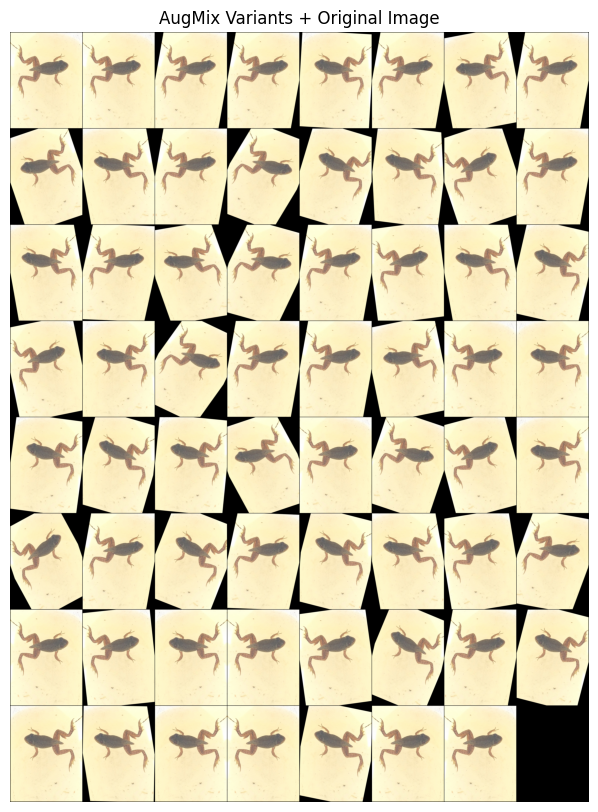

In [77]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

images = dataset[666][0]

images.shape

# Create a grid — 8x8 layout by default (you can change nrow)
grid = make_grid(images, nrow=8, padding=2)

grid_np = grid.permute(1, 2, 0).cpu().numpy()

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(grid_np)
plt.axis("off")
plt.title("AugMix Variants + Original Image")
plt.show()

In [11]:
correct = 0

prompt = torch.cat(
    [clip.tokenize(f"a photo of a {c}") for c in dataset.class_code_to_label.values()]
).to(device)


start = time.time()

logit_scale = torch.Tensor(torch.ones([]) * np.log(1 / 0.07)).exp()
i = 0
for image, label in tqdm(dataloader):
    pass
    # image = image.to(device)
    # label = label.to(device)

    # with torch.no_grad():
    #     text_features = model.encode_text(prompt)
    #     image_features = model.encode_image(image)

    #     image_features = image_features / image_features.norm(dim=1, keepdim=True)
    #     text_features = text_features / text_features.norm(dim=1, keepdim=True)

    #     # cosine similarity as logits
    #     # https://discuss.pytorch.org/t/difference-between-tensor-t-and-tensor-t/165640/7
    #     logits_per_image = logit_scale * image_features @ text_features.t()
    #     logits_per_text = logits_per_image.t()

    # if i == 100:
    #     break


# def select_confident_samples(logits, top):
#     batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)
#     idx = torch.argsort(batch_entropy, descending=False)[:int(batch_entropy.size()[0] * top)]
#     return logits[idx], idx

end = time.time()

accuracy = correct / len(dataset)
latency = (end - start) / len(dataset)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Latency: {latency * 1000:.2f} ms")

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 4/7500 [00:03<1:54:59,  1.09it/s]


KeyboardInterrupt: 